In [1]:
# my lib
import modules.tools as tools
import modules.utils as utils
from modules.simulation import simulator
from modules.config import api_key

In [2]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Decision makers

In [12]:
v_start = 100
v_end = 1000
t = 3
cagr = (v_end / v_start)**(1/t)

In [14]:
100*cagr

215.44346900318837

In [11]:
v_start*((cagr+1)**t)

1000.0000000000002

### pusht nigzarot

In [3]:
def should_buy(price_array,
               interval=1,
               filt_smooth=10,
               window_size=5,
               der_th = 0,
               second_th = 1e-10,
               verbose=0):
    
    '''
    simple decision rule based on whether the derivative is positive and the second deirivative is very positive
    '''
    

    
    fs = 1/(60*interval)
    x = price_array
    
    where_to_start=max(-len(price_array), -10*filt_smooth)
    x = price_array[where_to_start:]
    stop_dot, x_dot = tools.derivative(x, fs, filt_smooth=filt_smooth)
    stop_dotaim, x_dotaim = tools.second_derivative(x, fs, filt_smooth=filt_smooth)
    
    # stop_dot -= where_to_start
    # stop_dotaim -= where_to_start
    
    take_into_account = min(window_size, len(x_dot))
    mean_dot = np.mean(x_dot[-take_into_account:])
    
    take_into_account = min(window_size, len(x_dotaim))
    mean_dotaim = np.mean(x_dotaim[-take_into_account:])
    
    is_rising = (mean_dot > der_th)
    is_der_rising = (mean_dotaim > second_th)
    
    buy = is_rising and is_der_rising
    
    if verbose == 1 and buy or verbose == 2 :
        print('+'*100)
        # plt.figure()
        # plt.plot(price_array)
        # plt.title('Prices')
        # plt.axvline(len(price_array) + where_to_start, c='orange')
        # plt.show()

        plt.figure(figsize=(7, 3))
        plt.plot(x_dot, label='Signal')
        plt.plot(np.ones(len(x_dot))*mean_dot, label='Mean')
        plt.plot(np.ones(len(x_dot))*der_th, label='Thresh')
        plt.axvline(len(x_dot) - window_size, c='orange')
        plt.legend()
        plt.title('Derivative')
        plt.show()

        plt.figure(figsize=(7, 3))
        plt.plot(x_dotaim, label='Signal')
        plt.plot(np.ones(len(x_dotaim))*mean_dotaim, label='Mean')
        plt.plot(np.ones(len(x_dotaim))*second_th, label='Thresh')
        plt.axvline(len(x_dotaim) - window_size, c='orange')
        plt.title('Buying')
        plt.legend()
        plt.title('Second Derivative')
        plt.show()    
        print('+'*100)

        
    return buy



def should_sell(price_array,
                interval=1,
                filt_smooth=10,
                window_size=5,
                der_th=0, 
                second_th=-1e-10,
                verbose=0):
    
    '''
    simple decision rule based on whether the derivative is positive and the second deirivative is very positive
    '''
    
    fs = 1/(60*interval)
    x = price_array
    
    where_to_start=max(-len(price_array), -10*filt_smooth)
    x = price_array[where_to_start:]
    stop_dot, x_dot = tools.derivative(x, fs, filt_smooth=filt_smooth)
    stop_dotaim, x_dotaim = tools.second_derivative(x, fs, filt_smooth=filt_smooth)
    
    # stop_dot -= where_to_start
    # stop_dotaim -= where_to_start
    
    take_into_account = min(window_size, len(x_dot))
    mean_dot = np.mean(x_dot[-take_into_account:])
    
    take_into_account = min(window_size, len(x_dotaim))
    mean_dotaim = np.mean(x_dotaim[-take_into_account:])
    
    is_falling = (mean_dot < der_th)
    is_der_falling = (mean_dotaim < second_th)
        
    sell = is_falling and is_der_falling
        
    if verbose == 1 and sell or verbose == 2:
        print('+'*100)
        # plt.figure(figsize=(7, 3))
        # plt.plot(price_array)
        # plt.title('Prices')
        # plt.axvline(len(price_array) + where_to_start, c='orange')
        # plt.show()

        plt.figure(figsize=(7, 3))
        plt.plot(x_dot, label='Signal')
        plt.plot(np.ones(len(x_dot))*mean_dot, label='Mean')
        plt.plot(np.ones(len(x_dot))*der_th, label='Thresh')
        plt.axvline(len(x_dot) - window_size, c='orange')
        plt.legend()
        plt.title('Derivative')
        plt.show()

        plt.figure(figsize=(7, 3))
        plt.plot(x_dotaim, label='Signal')
        plt.plot(np.ones(len(x_dotaim))*mean_dotaim, label='Mean')
        plt.plot(np.ones(len(x_dotaim))*second_th, label='Thresh')
        plt.axvline(len(x_dotaim) - window_size, c='orange')
        plt.title('Selling')
        plt.legend()
        plt.title('Second Derivative')
        plt.show()
        print('+'*100)

        
        
    return sell




### moving avgs

In [4]:
def avgs_buy_rule(prices, fast_len=5, slow_len=20, verbose=0):
    # slow_len = len(prices)//20
    # fast_len = len(prices)//30

    lookback = int(slow_len*5)
    
    x = prices[-lookback:]
    
    fast_avg = tools.moving_avg(x, fast_len)
    slow_avg = tools.moving_avg(x, slow_len)
    
    buy = slow_avg[-1] < fast_avg[-1]
    
    if verbose == 1 and buy or verbose == 2:
        print('+'*100)
        t = np.arange(len(x))
        plt.plot(t, x, label='Signal')
        plt.plot(t[len(t)-len(fast_avg):], fast_avg, label='fast AVG')
        plt.plot(t[len(t)-len(slow_avg):], slow_avg, label='Slow AVG')
        plt.title('Buying')
        plt.legend()
        plt.show()
        print('+'*100)
    
    return buy

def avgs_sell_rule(prices, fast_len=5, slow_len=20, verbose=0):
    # slow_len = len(prices)//20
    # fast_len = len(prices)//30
    
    lookback = int(slow_len*1.5)
    
    x = prices[-lookback:]
    
    fast_avg = tools.moving_avg(x, fast_len)
    slow_avg = tools.moving_avg(x, slow_len)
    
    sell = slow_avg[-1] > fast_avg[-1]
    
    if verbose == 1 and sell or verbose == 2:
        print('+'*100)
        t = np.arange(len(x))
        plt.plot(t, x, label='Signal')
        plt.plot(t[len(t)-len(fast_avg):], fast_avg, label='fast AVG')
        plt.plot(t[len(t)-len(slow_avg):], slow_avg, label='Slow AVG')
        plt.title('Selling')
        plt.legend()
        plt.show()
        print('+'*100)
    
    return sell

### polyfit

In [5]:
def poly_buy(prices, interval=1, window_size=5, der_th=0, second_th=1e-10, verbose=0):
    
    x = prices[-window_size:]
    fs = 1/(60*interval)
    
    t = np.arange(window_size)/fs
    
    # poly1_coef = np.polyfit(t, x, deg=1)
    # poly1_obj = np.poly1d(poly1_coef)
    # da_1fit = poly1_obj(t)
    # derivative = np.mean(tools.derivative(da_1fit)[1])
    
    derivative = (x[-1] - x[-2])*fs
    
    poly2_coef = np.polyfit(t, x, deg=2)
    poly2_obj = np.poly1d(poly2_coef)
    da_2fit = poly2_obj(t)
    akmumiut = np.mean(tools.second_derivative(da_2fit)[1])
    
    buy = akmumiut > second_th and derivative > der_th 
    
    if verbose == 1 and buy or verbose == 2:
        print('+'*100)
        plt.figure(figsize=(7, 3))
        plt.plot(t, x, label='Signal')
        # plt.plot(t, da_1fit, label='Linear Fit')
        plt.plot(t, da_2fit, label='Parabola Fit')
        plt.title('Buying')
        plt.legend()
        plt.show()
        print('Akmumiut: {}, Thresh: {}'.format(akmumiut, second_th))
        print('Derivative: {}, Thresh: {}'.format(derivative, der_th))
        print('+'*100)
    return buy


def poly_sell(prices, interval=1, window_size=5, der_th=0, second_th=-1e-10, verbose=0):
    
    x = prices[-window_size:]
    fs = 1/(60*interval)
    
    t = np.arange(window_size)/fs
    
    # poly1_coef = np.polyfit(t, x, deg=1)
    # poly1_obj = np.poly1d(poly1_coef)
    # da_1fit = poly1_obj(t)
    # derivative = np.mean(tools.derivative(da_1fit)[1])
    derivative = (x[-1] - x[-2])*fs
    
    poly2_coef = np.polyfit(t, x, deg=2)
    poly2_obj = np.poly1d(poly2_coef)
    da_2fit = poly2_obj(t)
    akmumiut = np.mean(tools.second_derivative(da_2fit)[1])
    
    sell = akmumiut < second_th and derivative < der_th 
    
    if verbose == 1 and sell or verbose == 2:
        print('+'*100)
        plt.figure(figsize=(7, 3))
        plt.plot(t, x, label='Signal')
        # plt.plot(t, da_1fit, label='Linear Fit')
        plt.plot(t, da_2fit, label='Parabola Fit')
        plt.title('Selling')
        plt.legend()
        plt.show()
        print('Akmumiut: {}, Thresh: {}'.format(akmumiut, second_th))
        print('Derivative: {}, Thresh: {}'.format(derivative, der_th))
        print('+'*100)
        
    return sell

### hybrid

In [6]:
def hybrid_buy(x, logic='and', interval=1, window_size=5, der_th=0, second_th=1e-10 ,fast_len=5, slow_len=20, verbose=0):
    buy_poly = poly_buy(x, interval=interval, window_size=window_size, der_th=der_th, second_th=second_th, verbose=verbose)
    if not buy_poly: verbose = 0
    buy_avg = avgs_buy_rule(x, fast_len=fast_len, slow_len=slow_len, verbose=verbose)
    
    buy = buy_poly and buy_avg if logic == 'and' else buy_poly or buy_avg
    
    if buy and verbose: print('bought')
    
    return buy

def hybrid_sell(x, logic='and', interval=1, window_size=5, der_th=0, second_th=-1e-10 ,fast_len=5, slow_len=20, verbose=0):
    sell_poly = poly_sell(x, interval=interval, window_size=window_size, der_th=der_th, second_th=second_th, verbose=verbose)
    if not sell_poly: verbose = 0
    sell_avg = avgs_sell_rule(x, fast_len=fast_len, slow_len=slow_len, verbose=verbose)
    
    sell = sell_poly and sell_avg if logic == 'and' else sell_poly or sell_avg
    if sell and verbose: print('sold')
    return sell

# Simulator

### sinus

In [7]:
t_start = 0
t_end = 5
fs_sin = 2**10

N = int((t_end-t_start)*fs_sin)
t_sin = np.linspace(t_start, t_end, N)

f0 = 1
x_sin = 5 + np.sin(2*np.pi*f0*t_sin) - t_sin

### stock signal

In [23]:
symbols = [ 
    'meta',
    'GOOGL',
    'AAPL',
    'BP',  # bp oil
    'AMZN',
          ]

symbol = symbols[-1]

interval = 1

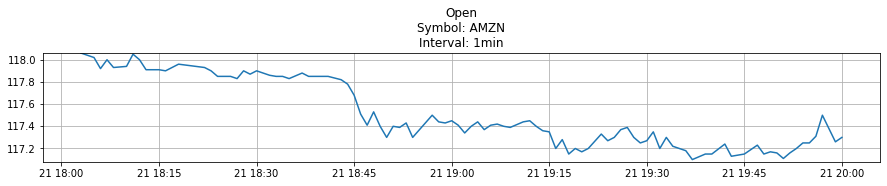

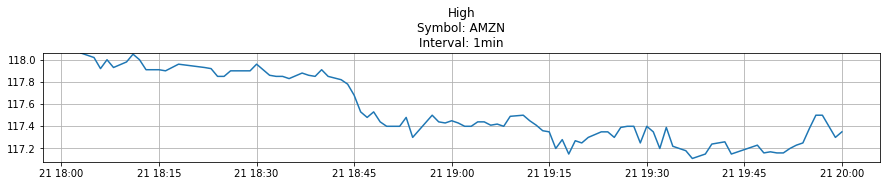

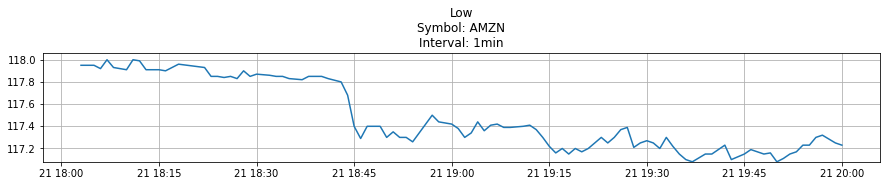

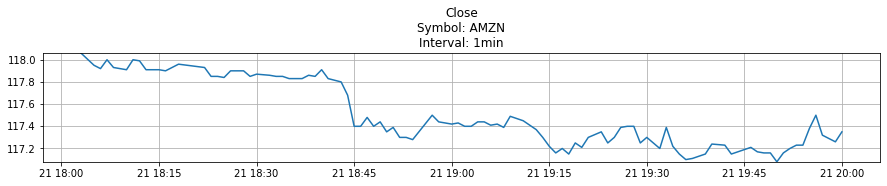

In [24]:
stock_dict, time_axis = utils.pull_stock(symbol, interval=interval, show_plots=True)

fs_stock = 1/(interval*60)  # convert interval to seconds and then to Hz
t_stock = np.arange(len(time_axis))
x_stock = np.array(stock_dict['close'])[::-1]

### simulation

In [25]:
fs = fs_stock
t = t_stock
x = x_stock

# fs = fs_sin
# t = t_sin
# x = x_sin

##### pusht rule

In [11]:
lookback = 15
window_size = 5

buy_params = {
    'interval': 1/(60*fs),
    'filt_smooth': lookback,
    'window_size': window_size,
    'der_th': 0,
    'second_th': 1e-10,
    'verbose': 0
}

sell_params = {
    'interval': 1/(60*fs),
    'filt_smooth': lookback,
    'window_size': window_size,
    'der_th': 0,
    'second_th': -1e-10,
    'verbose': 0
}

buy_func = should_buy
sell_func = should_sell

##### avg rule

In [12]:
lookback = 20

buy_params = {
    'fast_len': 2,
    'slow_len': 3,
    'verbose': 1,
}

sell_params = {
    'fast_len': 2,
    'slow_len': 3,
    'verbose': 1,
}

buy_func = avgs_sell_rule
sell_func = avgs_buy_rule

##### poly rule

In [28]:
lookback = 15
window_size = 5

buy_params = {
    'interval': 1/(60*fs),
    'window_size': window_size,
    'der_th': 0,
    'second_th': 1e-10,
    'verbose': 0
}

sell_params = {
    'interval': 1/(60*fs),
    'window_size': window_size,
    'der_th': 0,
    'second_th': -1e-10,
    'verbose': 0
}

buy_func = poly_buy
sell_func = poly_sell

##### hybrid rule

In [14]:
lookback = 5
window_size = 5

buy_params = {
    'logic': 'and',
    'interval': 1/(60*fs),
    'window_size': window_size,
    'der_th': 0,
    'second_th': -1e-10,
    'fast_len': 3,
    'slow_len': 5,
    'verbose': 0
}

sell_params = {
    'logic': 'and',
    'interval': 1/(60*fs),
    'window_size': window_size,
    'der_th': 0,
    'second_th': 1e-10,
    'fast_len': 5,
    'slow_len': 10,
    'verbose': 0
}

buy_func = hybrid_buy
sell_func = hybrid_sell

## simulate

Keren: 117.49280000000003
kesef: 116.94280000000002
Tsua: -0.4681137908025098%


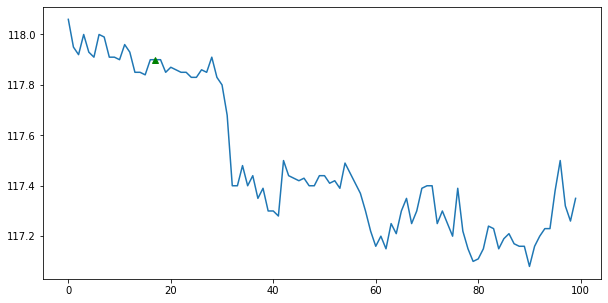

In [29]:
buys, sells = simulator(x,
                        fs,
                        lookback, 
                        buy_func=buy_func,
                        buy_params = buy_params,
                        sell_func=sell_func,
                        sell_params = sell_params
                       )

# Poly Fit

In [16]:
x_win = x[-window_size:]
    
t_win = np.arange(len(x_win))
poly_coef = np.polyfit(t_win, x_win, deg=1)
print(poly_coef)

[-3.7000e-02  9.8694e+01]


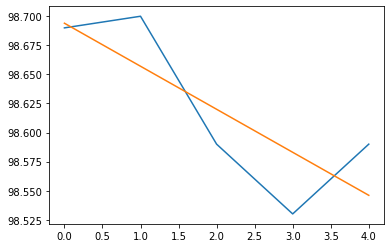

In [17]:
plt.figure()
plt.plot(t_win, x_win)
polypol = np.poly1d(poly_coef)
da_fit = polypol(t_win)
plt.plot(t_win, da_fit)

# Moving Avgs

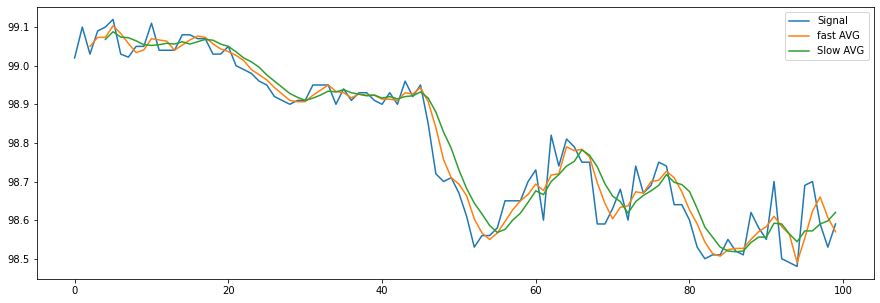

In [18]:
plt.figure(figsize=(15, 5))

slow_len = len(x)//20
fast_len = len(x)//30

fast_avg = tools.moving_avg(x, fast_len)
slow_avg = tools.moving_avg(x, slow_len)
    
plt.plot(t, x, label='Signal')
plt.plot(t[len(t)-len(fast_avg):], fast_avg, label='fast AVG')
plt.plot(t[len(t)-len(slow_avg):], slow_avg, label='Slow AVG')
plt.legend()
plt.show()

# Stock Signal

In [19]:
symbol = 'meta'
symbol = 'GOOGL'
symbol= 'AAPL'
symbol = 'BP'  # bp oil
stock = 'AMZN'

interval = 1

In [20]:
stock_dict, time_axis = utils.pull_stock(symbol, interval=interval)

fs = 1/(interval*60)  # convert interval to seconds and then to Hz
t = np.arange(len(time_axis))
x = stock_dict['open']

In [21]:
# filt_smooth = 10
# stop_dot, x_dot = tools.derivative(x, fs, filt_smooth=filt_smooth)
# stop_dotaim, x_dotaim = tools.second_derivative(x, fs, filt_smooth=filt_smooth)

# plt.figure()
# plt.plot(t, x)

# plt.figure()
# plt.plot(t[:stop_dot], x_dot)

# plt.figure()
# plt.plot(t[:stop_dotaim], x_dotaim)

In [22]:
filt_smooth = 1
window_size = 1

buys, sells = simulator(x, fs, filt_smooth, window_size, buy_params=None, sell_params=None)

TypeError: simulator() missing 1 required positional argument: 'sell_func'

In [ ]:
# print(should_buy(x, interval, filt_smooth=5, window_size=4, verbose=0))
# print(should_sell(x, interval, filt_smooth=5, window_size=4, verbose=0))

# Simulated Signal

In [ ]:
%matplotlib inline

In [ ]:
t_start = 0
t_end = 10
fs = 2**10

N = int((t_end-t_start)*fs)
t = np.linspace(t_start, t_end, N)

f0 = 1
x = 5 + np.sin(2*np.pi*f0*t)

In [ ]:
stop_dot, x_dot = tools.derivative(x, fs)
stop_dotaim, x_dotaim = tools.second_derivative(x, fs)

plt.figure()
plt.plot(t, x)

plt.figure()
plt.plot(t[:stop_dot], x_dot)

delta = np.mean(x_dotaim)
eps = 1e-13

plt.figure()
plt.plot(t[:stop_dotaim], x_dotaim)
# plt.ylim(delta-eps, delta+eps)

# plt.figure()
# plt.plot(smoothen(x_dotaim, how_much=5))
# plt.ylim(delta-eps, delta+eps)

In [ ]:
buys, sells

# storage

In [ ]:
def should_buy(price_array,
               interval,
               filt_smooth=10,
               window_size=5,
               der_th = 0,
               second_th = 1e-10,
               verbose=0):
    
    '''
    simple decision rule based on whether the derivative is positive and the second deirivative is very positive
    '''
    

    
    fs = 1/(60*interval)
    x = price_array
    
    where_to_start=max(-len(price_array), -10*filt_smooth)
    x = price_array[where_to_start:]
    stop_dot, x_dot = tools.derivative(x, fs, filt_smooth=filt_smooth)
    stop_dotaim, x_dotaim = tools.second_derivative(x, fs, filt_smooth=filt_smooth)
    
    # stop_dot -= where_to_start
    # stop_dotaim -= where_to_start
    
    take_into_account = min(window_size, len(x_dot))
    mean_dot = np.mean(x_dot[-take_into_account:])
    
    take_into_account = min(window_size, len(x_dotaim))
    mean_dotaim = np.mean(x_dotaim[-take_into_account:])
    
    is_rising = (mean_dot > der_th)
    is_der_rising = (mean_dotaim > second_th)
    
    
    
    if verbose == 1:
        plt.figure()
        plt.plot(price_array)
        plt.title('Prices')
        plt.axvline(len(price_array) + where_to_start, c='orange')
        plt.show()

        plt.figure()
        plt.plot(x_dot, label='Signal')
        plt.plot(np.ones(len(x_dot))*mean_dot, label='Mean')
        plt.plot(np.ones(len(x_dot))*der_th, label='Thresh')
        plt.axvline(len(x_dot) - window_size, c='orange')
        plt.legend()
        plt.title('Derivative')
        plt.show()

        plt.figure()
        plt.plot(x_dotaim, label='Signal')
        plt.plot(np.ones(len(x_dotaim))*mean_dotaim, label='Mean')
        plt.plot(np.ones(len(x_dotaim))*second_th, label='Thresh')
        plt.axvline(len(x_dotaim) - window_size, c='orange')
        plt.legend()
        plt.title('Second Derivative')
        plt.show()
    
        
    return is_rising and is_der_rising



def should_sell(price_array,
                interval,
                filt_smooth=10,
                window_size=5,
                der_th=0, 
                second_th=-1e-10,
                verbose=0):
    
    '''
    simple decision rule based on whether the derivative is positive and the second deirivative is very positive
    '''
    
    fs = 1/(60*interval)
    x = price_array
    
    where_to_start=max(-len(price_array), -10*filt_smooth)
    x = price_array[where_to_start:]
    stop_dot, x_dot = tools.derivative(x, fs, filt_smooth=filt_smooth)
    stop_dotaim, x_dotaim = tools.second_derivative(x, fs, filt_smooth=filt_smooth)
    
    # stop_dot -= where_to_start
    # stop_dotaim -= where_to_start
    
    take_into_account = min(window_size, len(x_dot))
    mean_dot = np.mean(x_dot[-take_into_account:])
    
    take_into_account = min(window_size, len(x_dotaim))
    mean_dotaim = np.mean(x_dotaim[-take_into_account:])
    
    is_falling = (mean_dot < der_th)
    is_der_falling = (mean_dotaim < second_th)
    
    
    
    if verbose == 1:
        plt.figure()
        plt.plot(price_array)
        plt.title('Prices')
        plt.axvline(len(price_array) + where_to_start, c='orange')
        plt.show()

        plt.figure()
        plt.plot(x_dot, label='Signal')
        plt.plot(np.ones(len(x_dot))*mean_dot, label='Mean')
        plt.plot(np.ones(len(x_dot))*der_th, label='Thresh')
        plt.axvline(len(x_dot) - window_size, c='orange')
        plt.legend()
        plt.title('Derivative')
        plt.show()

        plt.figure()
        plt.plot(x_dotaim, label='Signal')
        plt.plot(np.ones(len(x_dotaim))*mean_dotaim, label='Mean')
        plt.plot(np.ones(len(x_dotaim))*second_th, label='Thresh')
        plt.axvline(len(x_dotaim) - window_size, c='orange')
        plt.legend()
        plt.title('Second Derivative')
        plt.show()
        
    return is_falling and is_der_falling


